<a href="https://colab.research.google.com/github/vincebarokie/data-viz-guide/blob/main/w4_core1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Data Visualization Exercise (Core)

Submitted By: Raymund Vincent Ricabar

**Problem**

Instructions are found in the [README.md](https://github.com/vincebarokie/data-viz-guide/blob/main/README.md) section of this repo.

## TODOS:

- [x] Load the file to a DataFrame
- [x] Data Prep/Cleaning
- [x] Exploratory Visualization

### Load the file to a Data Frame.

**Mount Drive**

In [197]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [198]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# some additional imports
import matplotlib as mpl
import matplotlib.dates as mdates

from matplotlib.ticker import FuncFormatter

# printing the current version of the packages in Colab
print('- Package Versions:')
print(f'\tMatplotlib = {mpl.__version__}')
print(f'\tPandas = {pd.__version__}')
print(f'\tSeaborn = {sns.__version__}')

- Package Versions:
	Matplotlib = 3.2.2
	Pandas = 1.3.5
	Seaborn = 0.11.2


**Load the dataset**

In [199]:
# load the file to df
DATA_FOLDER = '/content/drive/MyDrive/CodingDojo_DS/dataset_files/'
filename = 'data_file_europe_power_sector_2020.xlsx'
df = pd.read_excel(DATA_FOLDER+filename)
df.head()

,Year,Area,Variable,Generation (TWh),Share of production (%),Change on last year (%),Change on last year (TWh)
0,2000,Austria,Fossil,16.418859,27.432215,NaN,NaN
1,2000,Austria,Coal,5.727000,9.568527,NaN,NaN
2,2000,Austria,Hard Coal,4.435000,7.409886,NaN,NaN
3,2000,Austria,Lignite,1.292000,2.158641,NaN,NaN
4,2000,Austria,Gas,7.851000,13.117252,NaN,NaN


### Data Prep/Cleaning

1. **Select Columns/Variables**
    - select only necessary variables for exploration and drop the rest.

In [200]:
# select the columns to use.
cols_to_use = ['Year', 'Area', 'Variable', 'Generation (TWh)', 'Share of production (%)', 'Change on last year (%)', 'Change on last year (TWh)']
df = df[cols_to_use].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10710 entries, 0 to 10709
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       10710 non-null  int64  
 1   Area                       10710 non-null  object 
 2   Variable                   10710 non-null  object 
 3   Generation (TWh)           10710 non-null  float64
 4   Share of production (%)    8820 non-null   float64
 5   Change on last year (%)    8611 non-null   float64
 6   Change on last year (TWh)  10200 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 585.8+ KB


2. **Identify and address duplicates**

    - find duplicates from the DataFrame and drop

In [201]:
# identify any duplicated rows and drop (keep='first') if any
print(f'We found {df.duplicated().sum()} duplicated rows in this DataFrame.')

# drop duplicated rows if any and retain the DataFrame if none.
if df.duplicated().sum() > 0:
  print('We are dropping these duplicated rows.')
  clean_df = df.drop_duplicates()
else:
  print('Since there are 0 duplicated rows, it is safe to continue!')
  clean_df = df

print(clean_df.shape)

We found 0 duplicated rows in this DataFrame.
Since there are 0 duplicated rows, it is safe to continue!
(10710, 7)


3. **Identify and address missing values**

  - find columns with missing values and address them.
    - step 1 - drop columns if >= 50% missing values
    - step 2 - drop rows if < 2.5% missing values of DataFrame size
    - step 3 - categorical imputation using mode
    - step 4 - numerical imputation using mean/median

In [202]:
from pandas.core.frame import DataFrame
# step 1
def _drop_cols(df, which_col):
  df.dropna(axis = 1, subset = which_col, inplace = True)
  return df

# step 2
def _drop_rows(df, which_col):
  df.dropna(subset = which_col, inplace = True)
  return df

# step 3 - categorical imputaion - mode
def _impute_categorical(df, groupby_name, identifier):
  identifier_mode = pd.DataFrame(df.groupby(groupby_name)[identifier].apply(pd.Series.mode)).reset_index().drop('level_1', axis=1)

  # merge the series to the main dataframe and drop and rename identifier columns
  clean_df = df.merge(identifier_mode, on=identifier)
  clean_df[f'{identifier}_x'].fillna(clean_df[f'{identifier}_y'], inplace=True)
  clean_df = clean_df.rename(columns = {f'{identifier}_x' : f'{identifier}'}).drop(f'{identifier}_y', axis = 1)

  print(clean_df[identifier].isna().sum())
  return clean_df

# step 4 - numerical imputaiton - mean/median/0/min/max
def _impute_numerical(df, which_col, impute_with=0):
  # set the impute value
  if impute_with == 0:
    impute_value = 0
  elif impute_with == 'mean':
    impute_value = df[which_col].mean()
  elif impute_with == 'median':
    impute_value = df[which_col].median()
  elif impute_with == 'min':
    impute_value = df[which_col].min()
  else:
    impute_value = df[which_col].max()
  
  # perform the imputation based on the selected value.
  df[which_col] = df[which_col].fillna(impute_value)

  return df


In [203]:
#identify columns with missing values, dtypes and percent of missing values compared to df
cols_with_nulls = clean_df.columns[clean_df.isnull().any()]

#index the cols_with_nulls and find the dtype and percent of missing values compared to df size
print('- Columns with missing values:') 
for col in cols_with_nulls: 
  perct_difference = clean_df[col].isna().sum() / len(clean_df.index) 
  print(f"\tColumn Name: '{col}', Column dtype: {clean_df[col].dtype}, perct_difference: {round(perct_difference*100,2)}%")

  #step 1 - if missing values is 50% or more than the DataFrame size
  if perct_difference > 0.5: 
    clean_df = _drop_cols(clean_df, col) 
  else: 
    clean_df = clean_df

  #step 2 - if missing values are < 2.5% than the DataFrame size
  if perct_difference < 0.025: 
    clean_df = _drop_rows(clean_df, col) 
  else: 
    clean_df = clean_df

  #step 3 - categorical imputation
  if clean_df[col].dtype == 'object': 
    groupby_name = None #change this to the correct groupby column if there missing categorical variables 
    clean_df = _impute_categorical(clean_df, groupby_name, col) 
  else: 
    clean_df = clean_df

  #setp 4 - numerical imputation
  if clean_df[col].dtype != 'object':
    # set the impute_with to [0, mean, median, min, max] depending on the variable you are imputing.
    # with this dataset, we are imputing with 0 since most of the missing values are missing due 
    # to some comparrison last year which is not in the dataset or there are no data for that specific
    # Variable column
    clean_df = _impute_numerical(clean_df, col)

print('\nAfter cleaning and imputing missing values, there are:') 
clean_df.isna().sum()

- Columns with missing values:
	Column Name: 'Share of production (%)', Column dtype: float64, perct_difference: 17.65%
	Column Name: 'Change on last year (%)', Column dtype: float64, perct_difference: 19.6%
	Column Name: 'Change on last year (TWh)', Column dtype: float64, perct_difference: 4.76%

After cleaning and imputing missing values, there are:


Year                         0
Area                         0
Variable                     0
Generation (TWh)             0
Share of production (%)      0
Change on last year (%)      0
Change on last year (TWh)    0
dtype: int64

4. **Fix inconsistent categorical values**

    - find inconsistencies on categorical variables and fix them. (ex: [cat, Cats, cats, Cat])

In [204]:
# check for categorical variable inconsistencies
# first grab only all categorical variables and create a new DataFrame
cat_df = clean_df.select_dtypes(include = 'object')

# iterate these variables and print all unique values to find the inconsistencies. 
print('- Categorical Variables')
for col in list(cat_df):
  print(col + ':')
  print(f" \t> Count of unique values: {str(len(cat_df[col].unique()))}" )
  print(cat_df[col].unique())

num_df = clean_df.select_dtypes(include = [np.number])
print('- Numeric Variables')
for col in list(num_df):
  print(col + ':')
  print(f" \t> Count of unique values: {str(len(num_df[col].unique()))}" )
  print(num_df[col].unique())

- Categorical Variables
Area:
 	> Count of unique values: 30
['Austria' 'Belgium' 'Bulgaria' 'Croatia' 'Cyprus' 'Czech Republic'
 'Denmark' 'Estonia' 'EU-27' 'EU27+1' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'Ireland' 'Italy' 'Latvia' 'Lithuania' 'Luxembourg'
 'Malta' 'Netherlands' 'Poland' 'Portugal' 'Romania' 'Slovakia' 'Slovenia'
 'Spain' 'Sweden' 'United Kingdom']
Variable:
 	> Count of unique values: 17
['Fossil' 'Coal' 'Hard Coal' 'Lignite' 'Gas' 'Other fossil' 'Nuclear'
 'Renewables' 'Hydro' 'Wind and solar' 'Wind' 'Solar' 'Bioenergy'
 'Other renewables' 'Production' 'Net imports' 'Demand']
- Numeric Variables
Year:
 	> Count of unique values: 21
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020]
Generation (TWh):
 	> Count of unique values: 8104
[ 16.418859     5.727        4.435      ... 305.47647023  18.2130882
 323.68955843]
Share of production (%):
 	> Count of unique values: 6674
[2.74322149e+01 9.56852693e+0

*After running the code above, we found no inconsistencies in the categorical variables*

5. **Check for DataFrame summary statistics**

    - you can run `.describe()` method to achieve this

In [205]:
clean_df.describe()

,Year,Generation (TWh),Share of production (%),Change on last year (%),Change on last year (TWh)
count,10710.000000,10710.000000,10710.000000,1.071000e+04,10710.000000
mean,2010.000000,73.872794,12.282539,inf,0.176356
std,6.055583,305.631550,20.556345,NaN,10.991492
min,2000.000000,-77.034000,-2.283799,-2.282727e+04,-166.200793
25%,2005.000000,0.062750,0.000000,-2.202591e+00,-0.104810
50%,2010.000000,4.348132,1.965882,0.000000e+00,0.000000
75%,2015.000000,26.433729,15.666894,1.017242e+01,0.524811
max,2020.000000,3374.604373,100.000000,inf,143.012838


*After running `clean_df.describe()` we found that the variable `Change on last year (%)` has an `inf` value, since this is a percentage column, INF usually happens when you divide a number by 0 in mathematical calculations, therefore we will impute these values as 0 instead.*

In [206]:
clean_df['Change on last year (%)'] = clean_df['Change on last year (%)'].replace([np.inf, -np.inf], 0)
clean_df.describe()

,Year,Generation (TWh),Share of production (%),Change on last year (%),Change on last year (TWh)
count,10710.000000,10710.000000,10710.000000,10710.000000,10710.000000
mean,2010.000000,73.872794,12.282539,15.622190,0.176356
std,6.055583,305.631550,20.556345,528.209693,10.991492
min,2000.000000,-77.034000,-2.283799,-22827.272727,-166.200793
25%,2005.000000,0.062750,0.000000,-2.202591,-0.104810
50%,2010.000000,4.348132,1.965882,0.000000,0.000000
75%,2015.000000,26.433729,15.666894,9.590997,0.524811
max,2020.000000,3374.604373,100.000000,46500.000000,143.012838


**Data is cleaned and ready for Exploratory Visualization**

### Exploratory Visualization

TODOS:

- [x] Tell a story about your data using some visualization
- [x] Add some context to your visualizations via the text blocks

In [207]:
# run df.info and df.head to get another look at the data
display(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10710 entries, 0 to 10709
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       10710 non-null  int64  
 1   Area                       10710 non-null  object 
 2   Variable                   10710 non-null  object 
 3   Generation (TWh)           10710 non-null  float64
 4   Share of production (%)    10710 non-null  float64
 5   Change on last year (%)    10710 non-null  float64
 6   Change on last year (TWh)  10710 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 585.8+ KB


None

,Year,Area,Variable,Generation (TWh),Share of production (%),Change on last year (%),Change on last year (TWh)
0,2000,Austria,Fossil,16.418859,27.432215,0.0,0.0
1,2000,Austria,Coal,5.727000,9.568527,0.0,0.0
2,2000,Austria,Hard Coal,4.435000,7.409886,0.0,0.0
3,2000,Austria,Lignite,1.292000,2.158641,0.0,0.0
4,2000,Austria,Gas,7.851000,13.117252,0.0,0.0


**Original Visualization from Makeover Monday**

A timeseries line chart that show the trend of Fossil and Renewables and their sub-cateory `[Coal, Wind and Solar]` over time.

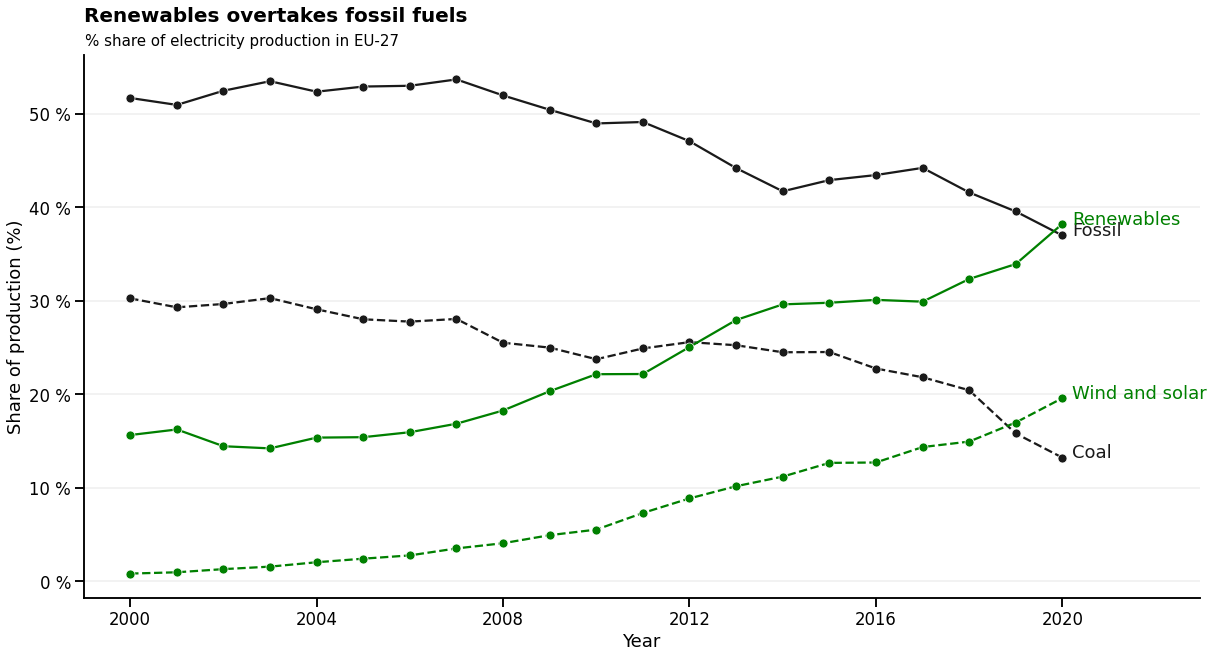

In [208]:
## filter necessary Variable columns.
energy_sources_category = ['Fossil', 'Coal', 'Renewables', 'Wind and solar']
country_list = ['EU-27']

# filter DataFrame based on the set filter
esc_filter = clean_df['Variable'].isin(energy_sources_category)
country_filter = clean_df['Area'].isin(country_list)
esc_df_ts = clean_df.loc[country_filter & esc_filter, :]

# set fig,ax 
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(20,10))

# plot the line graph
sns.lineplot(
    data = esc_df_ts, 
    x = pd.to_datetime(clean_df['Year'], format='%Y'), 
    y = 'Share of production (%)', 
    hue='Variable',  
    marker = 'o',
    ci = None,
    palette = ['k','k','green','green'],
    legend=None
  )

# set line styles
ax.lines[1].set_linestyle('--')
ax.lines[3].set_linestyle('--')

# removing spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set titles and subtitles
plt.title('Renewables overtakes fossil fuels', fontsize = 20, fontweight='bold', loc='left', y = 1.05)
plt.suptitle('% share of electricity production in EU-27', fontsize = 15, x = 0.235, y = 0.91)

# yaxis format
generation_fmt = mpl.ticker.StrMethodFormatter('{x:,.0f} %')
ax.yaxis.set_major_formatter(generation_fmt)

# code grabbed from : https://lost-stats.github.io/Presentation/Figures/line_graph_with_labels_at_the_beginning_or_end.html
# Add the text--for each line, find the end, annotate it with a label, and
# adjust the chart axes so that everything fits on.
for line, name in zip(ax.lines, energy_sources_category):
	y = line.get_ydata()[-1]
	x = line.get_xdata()[-1]
	if not np.isfinite(y):
	    y=next(reversed(line.get_ydata()[~line.get_ydata().mask]),float("nan"))
	if not np.isfinite(y) or not np.isfinite(x):
	    continue     
	text = ax.annotate(name,
		       xy=(x, y),
		       xytext=(10, 0),
		       color=line.get_color(),
		       xycoords=(ax.get_xaxis_transform(),ax.get_yaxis_transform()),
		       textcoords="offset points")
	text_width = (text.get_window_extent(
	fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width)
	if np.isfinite(text_width):
		ax.set_xlim(ax.get_xlim()[0], text.xy[0] + text_width * 1.05)
  
# set y grid visible
plt.grid(visible = True, axis = 'y', color = 'grey', linewidth = 0.2)



*As shown in the visual above, Renewables has taken over Fossil fuels in terms of % share of electric production in EU-27 areas in the year 2020 and the trend is looking positive for the Renewables and Fossil fuels are in the decreasing trends.*

**Top 10 Renewable Sources by Country Dashboard**

A Horizontal bar graph showing the top 10 renewable sources by country

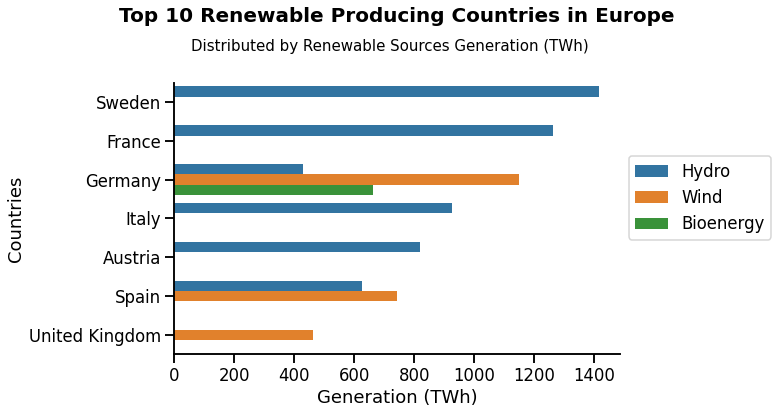

In [209]:
# set renewable list
energy_sources_renewable_sub_category = ['Hydro',
                                         'Wind',
                                         'Solar',
                                         'Bioenergy',
                                         'Other renewables']

not_country_list = ['EU-27', 'EU27+1']

# set the renewable filter
renewable_filter = clean_df['Variable'].isin(energy_sources_renewable_sub_category)
not_country_filter = clean_df['Area'].isin(not_country_list)
# filter the dataframe and sort by generation and get the top 10
renewable_df = clean_df.loc[~not_country_filter & renewable_filter].copy()
area_var_agg_sum_gen = renewable_df.groupby(['Area', 'Variable'])[['Generation (TWh)']].sum()
top10_renewable_country = area_var_agg_sum_gen.sort_values('Generation (TWh)', ascending=False).reset_index().head(10)

# set fig and axes of the plot
sns.set_context('talk')
fig, ax = plt.subplots(figsize = (8,5))

# plot the data to a horizontal bar chart
sns.color_palette('pastel')
sns.barplot(
    x = 'Generation (TWh)', 
    y = 'Area', 
    hue = 'Variable', 
    data = top10_renewable_country, 
    # color = 'dark green', 
    ci = None
  )

# set the legend
ax.legend(bbox_to_anchor = (1, 0.76), frameon = True)
ax.set(ylabel = 'Countries')

# remove plot borders or spines
sns.despine(right=True, top=True)

# set titles and subtitles
plt.title('Top 10 Renewable Producing Countries in Europe', fontsize = 20, fontweight='bold', loc='center', y = 1.2)
plt.suptitle('Distributed by Renewable Sources Generation (TWh)', fontsize = 15,  y = 1)

plt.show()


*Sweden is the top renewable energy producing country in EU for the period of time this dataset is recorded and the energy source they are using is Hydro. Next in line is France with a Hydro plant as well. Wind Energy sources are produced by Germany, Spain and United Kingdom. While Germany is the only Bioenergy producing country in the Top 10.*